In [1]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy import units as u
import sncosmo
import matplotlib.pylab as plt

from mcmc_tools_tess import *
from useful_functions import lcImport

In [2]:
ab = sncosmo.get_magsystem('ab')
tess_response = pd.read_csv('./tess_response_curve.csv',header=0,names=['wl_nm','trans'])
tess_response['wl_ang'] = (np.array(tess_response['wl_nm']) * u.nm).to_value('angstrom')

atlaso_response = pd.read_csv('./atlas_o.csv',header=0,names=['wl_ang','trans'])

sn2020bpi_ztf = pd.read_csv('./sn2020bpi_ztf.csv',header=0)
sn2020bpi_ztf['BTJD'] = Time(sn2020bpi_ztf['mjd'],format='mjd').jd - 2457000.0
sn2020bpi_ztf['magap_rolling'] = sn2020bpi_ztf['magap'].rolling(12).median()
sn2020bpi_ztf['flux'] = [ab.band_mag_to_flux(sn2020bpi_ztf['magap'][i], 'ztfr') for i in range(len(sn2020bpi_ztf['magap']))]
sn2020bpi_ztf['flux_rolling'] = sn2020bpi_ztf['flux'].rolling(12).median()

In [3]:
sn2020bpi_s21_dir = './Fausnaugh/sector21/cam3_ccd2/lc/lc_2020bpi_cleaned'
sn2020bpi_s21 = lcImport(sn2020bpi_s21_dir)
sn2020bpi_s21['cts_median'] = sn2020bpi_s21['cts'].rolling(24).median()
sn2020bpi_s21['e_cts_median'] = sn2020bpi_s21['e_cts'].rolling(24).median()
sn2020bpi_s21['mjd'] = Time(sn2020bpi_s21['BTJD']+2457000.0, format='jd').mjd

sn2020bpi_s22_dir = './Fausnaugh/sector22/cam3_ccd1/lc/lc_2020bpi_cleaned'
sn2020bpi_s22 = lcImport(sn2020bpi_s22_dir)
sn2020bpi_s22['cts_median'] = sn2020bpi_s22['cts'].rolling(24).median()
sn2020bpi_s22['e_cts_median'] = sn2020bpi_s22['e_cts'].rolling(24).median()
sn2020bpi_s22['mjd'] = Time(sn2020bpi_s22['BTJD']+2457000.0, format='jd').mjd

sn2020bpi_s22_fix = (1912,1914.5)
sn2020bpi_s22_fixed = sn2020bpi_s22.query('BTJD > 1900')
sn2020bpi_s22_fixed = sn2020bpi_s22_fixed[(sn2020bpi_s22_fixed['BTJD'] < sn2020bpi_s22_fix[0]) | (sn2020bpi_s22_fixed['BTJD'] > sn2020bpi_s22_fix[1])]

sn2020bpi_s21s22 = pd.concat([sn2020bpi_s21,sn2020bpi_s22_fixed])
sn2020bpi_s21s22['cts_bkg_model_sub'] = sn2020bpi_s21s22['cts'] - sn2020bpi_s21s22['bkg_model']

In [4]:
tess_start_mjd = sn2020bpi_s21s22['mjd'].min()
tess_end_mjd = sn2020bpi_s21s22['mjd'].max()
sn2020bpi_ztf_r = sn2020bpi_ztf.query('fid == 2 & mjd > @tess_start_mjd & mjd < @tess_end_mjd').reset_index()

In [5]:
sn2020bpi_ztf_r.keys()

Index(['index', 'candid_str', 'oid', 'candid', 'mjd', 'fid', 'diffmaglim',
       'magpsf', 'magap', 'sigmapsf', 'sigmagap', 'ra', 'dec', 'sigmara',
       'sigmadec', 'isdiffpos', 'distpsnr1', 'sgscore1', 'field', 'rcid',
       'magnr', 'sigmagnr', 'rb', 'magpsf_corr', 'magap_corr', 'sigmapsf_corr',
       'sigmagap_corr', 'has_stamps', 'parent_candid', 'BTJD', 'magap_rolling',
       'flux', 'flux_rolling'],
      dtype='object')

In [6]:
tess_2020bpi = pd.read_csv('JhaData/TESS_SN2020bpi.csv')
tess_2020bpi['mjd'] = tess_2020bpi['mjd'] - np.min(tess_2020bpi['mjd'])
tess_2020bpi.head()

BTJD      mjd        cts      e_cts  bkg_model  raw_flux    e_flux  \
0  1870.44408  0.00000 -5339.0302  1368.8706  1502.1435 -0.030663  0.007862   
1  1870.44408  0.00000 -5334.2775  1367.3354  1502.1435 -0.030636  0.007853   
2  1870.46491  0.02083 -6841.1413  1375.3282  1502.1435 -0.039290  0.007899   
3  1870.46491  0.02083 -6820.1378  1373.8129  1502.1435 -0.039169  0.007890   
4  1870.48574  0.04166 -2219.7583  1400.7610  1501.2344 -0.012748  0.008045   

   bkg_model_flux  corr_flux  
0        0.008627   0.002060  
1        0.008627   0.002085  
2        0.008627  -0.006033  
3        0.008627  -0.005920  
4        0.008622   0.018870

In [7]:
ztf_2020bpi = pd.read_csv('JhaData/ztf_SN2020bpi.csv')
ztf_2020bpi['flux_err'] = 0.008*np.ones(len(ztf_2020bpi))
ztf_2020bpi['mjd'] = ztf_2020bpi['mjd'] - np.min(ztf_2020bpi['mjd'])
ztf_2020bpi.head()

BTJD       mjd      magap  sig_magap      flux  flux_err
0  1879.870567  0.000000  19.729799     0.2218  0.014224     0.008
1  1881.011065  1.140498  19.959801     0.2436  0.011509     0.008
2  1881.031343  1.160775  19.473101     0.1538  0.018018     0.008
3  1881.843854  1.973287  19.660400     0.2291  0.015163     0.008
4  1882.032546  2.161979  19.363001     0.1425  0.019941     0.008

In [8]:
tess_2020bpi.rename(columns={'raw_flux':'flux','e_flux':'flux_err'},inplace=True)
tess_2020bpi.head()

BTJD      mjd        cts      e_cts  bkg_model      flux  flux_err  \
0  1870.44408  0.00000 -5339.0302  1368.8706  1502.1435 -0.030663  0.007862   
1  1870.44408  0.00000 -5334.2775  1367.3354  1502.1435 -0.030636  0.007853   
2  1870.46491  0.02083 -6841.1413  1375.3282  1502.1435 -0.039290  0.007899   
3  1870.46491  0.02083 -6820.1378  1373.8129  1502.1435 -0.039169  0.007890   
4  1870.48574  0.04166 -2219.7583  1400.7610  1501.2344 -0.012748  0.008045   

   bkg_model_flux  corr_flux  
0        0.008627   0.002060  
1        0.008627   0.002085  
2        0.008627  -0.006033  
3        0.008627  -0.005920  
4        0.008622   0.018870

In [9]:
tess_cut = tess_2020bpi.copy(deep=True)
tess_cut = tess_cut[(tess_cut.mjd > 1) & (tess_cut.mjd < 13.5)]
tess_cut_0 = tess_cut.copy(deep=True)
tess_cut_0['flux'] = tess_cut['flux'] - np.min(tess_cut['flux'])
tess_cut_0['flux'] = tess_cut_0['flux'] - np.mean(tess_cut_0['flux'][tess_cut_0.mjd < 6])

ztf_cut = ztf_2020bpi.copy(deep=True)
ztf_cut = ztf_cut[(ztf_cut.mjd > 0) & (ztf_cut.mjd < 10)]
ztf_cut_0 = ztf_cut.copy(deep=True)
ztf_cut_0['flux'] = ztf_cut['flux'] - np.min(ztf_cut['flux'])
ztf_cut_0['flux'] = ztf_cut_0['flux'] - np.mean(ztf_cut_0['flux'][ztf_cut_0.mjd < 3])

In [10]:
err_model = lambda slope, mjd: mjd*slope

tess_cut_err = tess_cut.copy(deep=True)
tess_cut_err['flux_err'] = np.sqrt(tess_cut_err['flux_err']**2.0 + err_model(5e-5,tess_cut['mjd']))

ztf_cut_err = ztf_cut.copy(deep=True)
ztf_cut_err['flux_err'] = np.sqrt(ztf_cut_err['flux_err']**2.0 + err_model(5e-5,ztf_cut['mjd']))

In [20]:
def model_0(data, t0, a, power, offset):
    ret = np.zeros(len(data))
    ret[data-t0 > 0] = (a) * (data[data-t0 > 0] - t0)**power
    ret+=offset
    return ret

def model_1(data, t0, a, power, offset):
    ret = np.zeros(len(data))
    ret[data-t0 > 0] = (a**power) * (data[data-t0 > 0] - t0)**power
    ret+=offset
    return ret

def model_2(data, t0, a, power, offset):
    ret = np.zeros(len(data))
    ret[data-t0 > 0] = (a**(1./power)) * (data[data-t0 > 0] - t0)**power
    ret+=offset
    return ret

def model_3(data, t0, a, power, offset):
    ret = np.zeros(len(data))
    ret[data-t0 > 0] = (a**(power/3.0)) * (data[data-t0 > 0] - t0)**power
    ret+=offset
    return ret

def logl(data, model, theta):
    t0,a,sigma,power,offset = theta
    var = (data['flux_err']**2 + sigma**2)
    loglike = -0.5 * (np.sum(np.log(2*np.pi*var) + ((data['flux'] - model(data['flux'],t0,a,power,offset))**2 / var) ))
    return loglike

def fullEmceePlot(data, guess, scale, model):
    samples = doMCMC(data, guess, scale, model)
    percentiles = np.percentile(samples, [16,84], axis=0)
    t0 = np.median(samples[:,0])
    t0_p = percentiles[:,0]
    a = np.median(samples[:,1])
    a_p = percentiles[:,1]
    power = np.median(samples[:,3])
    power_p = percentiles[:,3]
    sigma = np.median(samples[:,2])
    sigma_p = percentiles[:,2]
    if len(guess) == 5:
        off = np.median(samples[:,4])
        off_p = percentiles[:,4]
    else:
        off = 0.0
        off_p = np.zeros(len(percentiles[:,0]))
     
    if model == 'model 0':
        mod = model_0(np.linspace(np.min(data['mjd']),np.max(data['mjd']),100), t0, a, power, off)
    elif model == 'model 1':
        mod = model_1(np.linspace(np.min(data['mjd']),np.max(data['mjd']),100), t0, a, power, off)
    elif model == 'model 2':
        mod = model_2(np.linspace(np.min(data['mjd']),np.max(data['mjd']),100), t0, a, power, off)
    elif model == 'model 3':
        mod = model_3(np.linspace(np.min(data['mjd']),np.max(data['mjd']),100), t0, a, power, off)
    
    plt.figure()
    plt.errorbar(data['mjd'],data['flux'],yerr=data['flux_err'],
             color='black',linestyle='',alpha=0.5)
    plt.plot(np.linspace(np.min(data['mjd']),np.max(data['mjd']),100),mod,'b')

(0.0, 0.075)

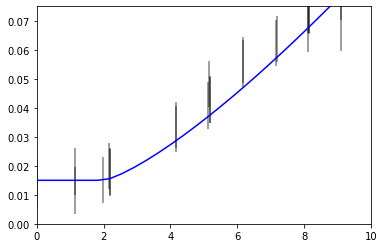

In [12]:
mod = model_0(np.linspace(np.min(ztf_2020bpi['mjd']),np.max(ztf_2020bpi['mjd']),100), 2, .005, 1.3, 0.015)
    
plt.figure()
plt.errorbar(ztf_2020bpi['mjd'],ztf_2020bpi['flux'],yerr=ztf_2020bpi['flux_err'],
         color='black',linestyle='',alpha=0.5)
plt.plot(np.linspace(np.min(ztf_2020bpi['mjd']),np.max(ztf_2020bpi['mjd']),100),mod,'b')
plt.xlim([0,10])
plt.ylim(0,0.075)

(-0.1, 0.1)

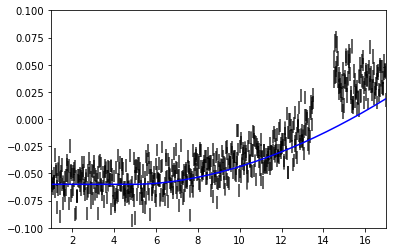

In [13]:
mod = model_0(np.linspace(np.min(tess_2020bpi['mjd']),np.max(tess_2020bpi['mjd']),100), 5, .0009, 1.8, -0.06)
    
plt.figure()
plt.errorbar(tess_2020bpi['mjd'],tess_2020bpi['flux'],yerr=tess_2020bpi['flux_err'],
         color='black',linestyle='',alpha=0.5)
plt.plot(np.linspace(np.min(tess_2020bpi['mjd']),np.max(tess_2020bpi['mjd']),100),mod,'b')
plt.xlim([1,17])
plt.ylim(-0.1,0.1)

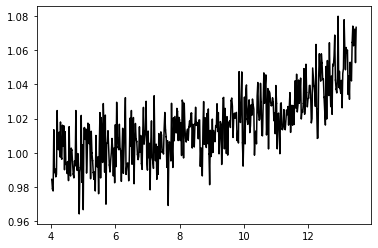

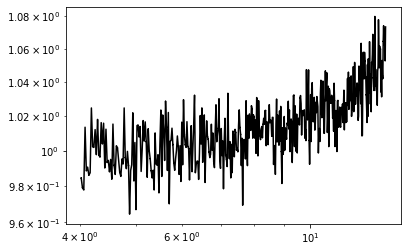

In [14]:
plt.figure()
plt.plot(tess_cut_0[tess_cut_0.mjd>4]['mjd'],tess_cut_0[tess_cut_0.mjd>4]['flux']+1,color='black')
plt.figure()
plt.loglog(tess_cut_0[tess_cut_0.mjd>4]['mjd'],tess_cut_0[tess_cut_0.mjd>4]['flux']+1,color='black')

In [15]:
guess_ztf = [2, 0.005, 0.0, 1.3]
guess_tess = [5, 0.0009, 0.0, 1.8]
scale = [0.05, 1e-6, 0.001, 0.005]

guess_ztf_off = [2, 0.005, 0.0, 1.3, 0.0]
guess_tess_off = [5, 0.0009, 0.0, 1.8, 0.0]
scale_off = [0.005, 1e-5, 0.001, 0.005, 0.001]

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [09:06<00:00,  5.49it/s]


done


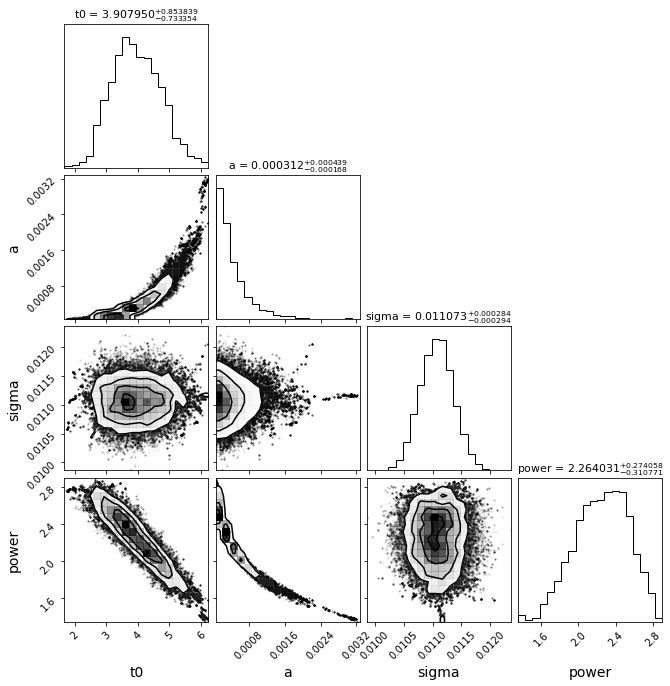

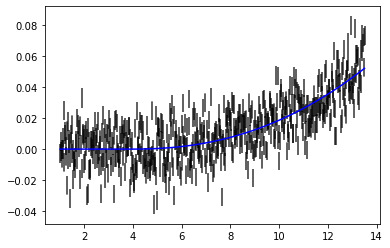

In [15]:
fullEmceePlot(tess_cut_0,guess_tess,scale,'model 0')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:32<00:00,  5.85it/s]


done


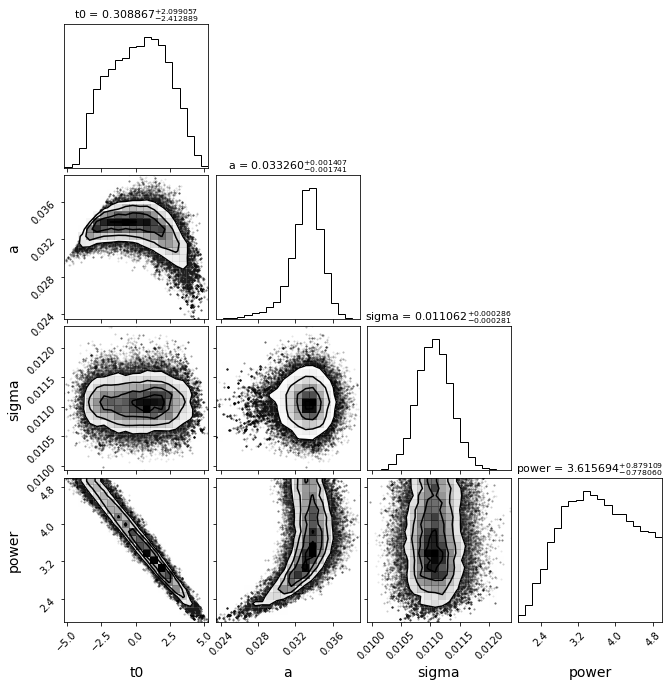

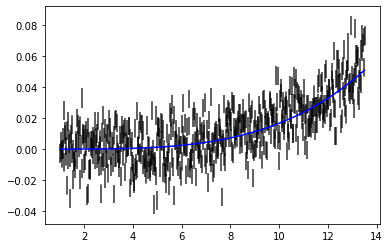

In [28]:
fullEmceePlot(tess_cut_0,[5, 0.03, 0.0, 3.2],scale,'model 1')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:40<00:00,  5.77it/s]


done


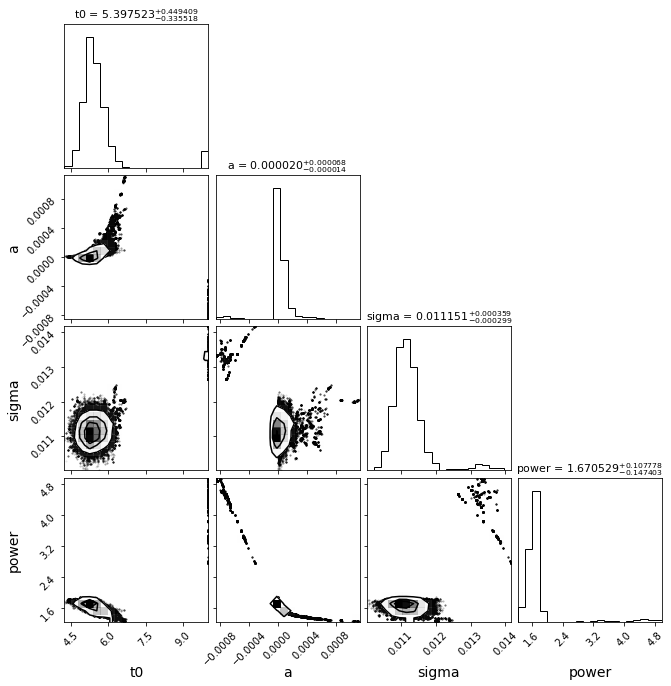

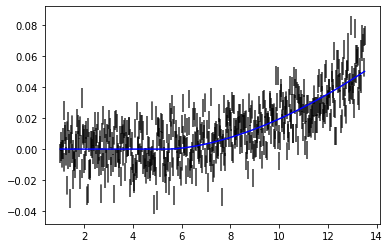

In [29]:
fullEmceePlot(tess_cut_0,[5, 0.00009, 0.0, 1.8],[0.05, 5e-7, 0.001, 0.005],'model 2')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:21<00:00,  5.98it/s]


done


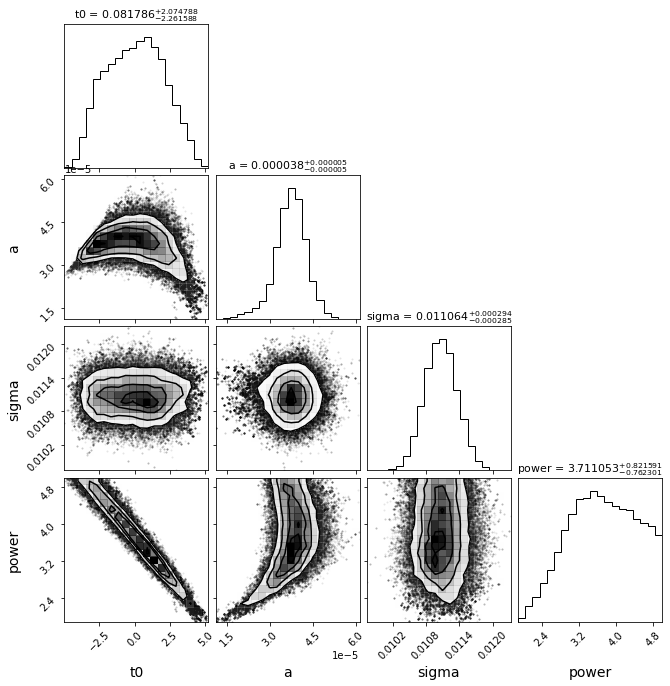

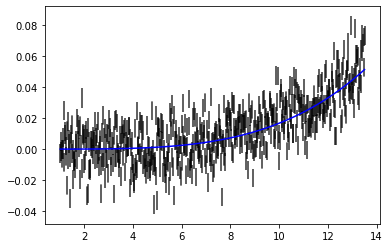

In [21]:
fullEmceePlot(tess_cut_0,[5, 0.00003, 0.0, 3.2],scale,'model 3')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:50<00:00,  5.66it/s]


done


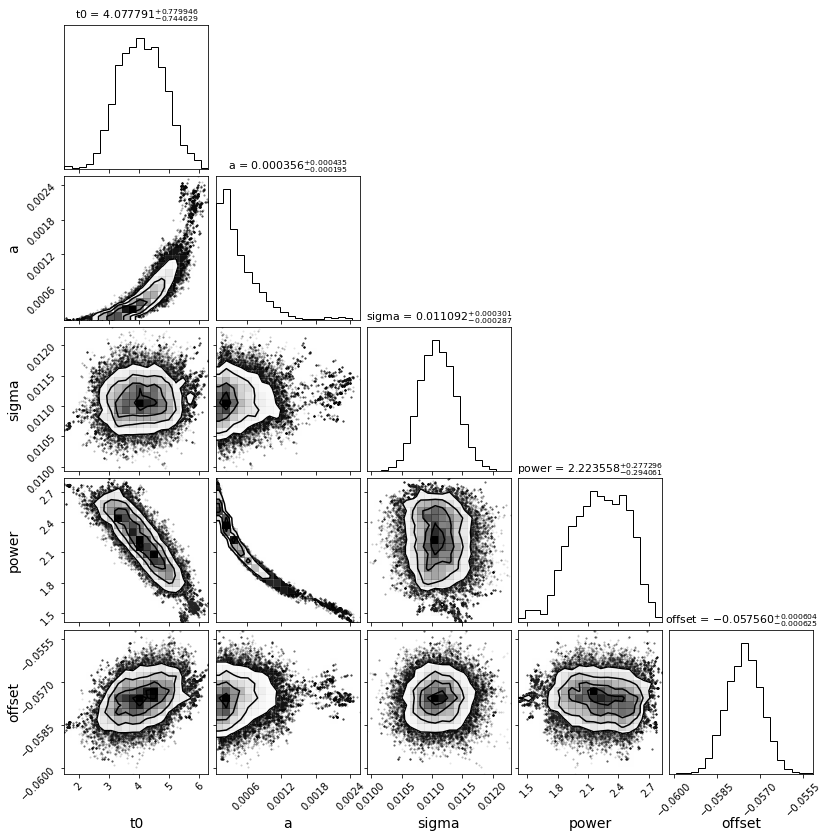

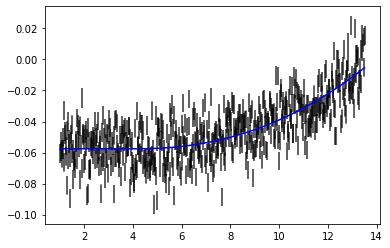

In [18]:
fullEmceePlot(tess_cut,guess_tess_off,scale_off,'model 0')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:45<00:00,  5.71it/s]


done


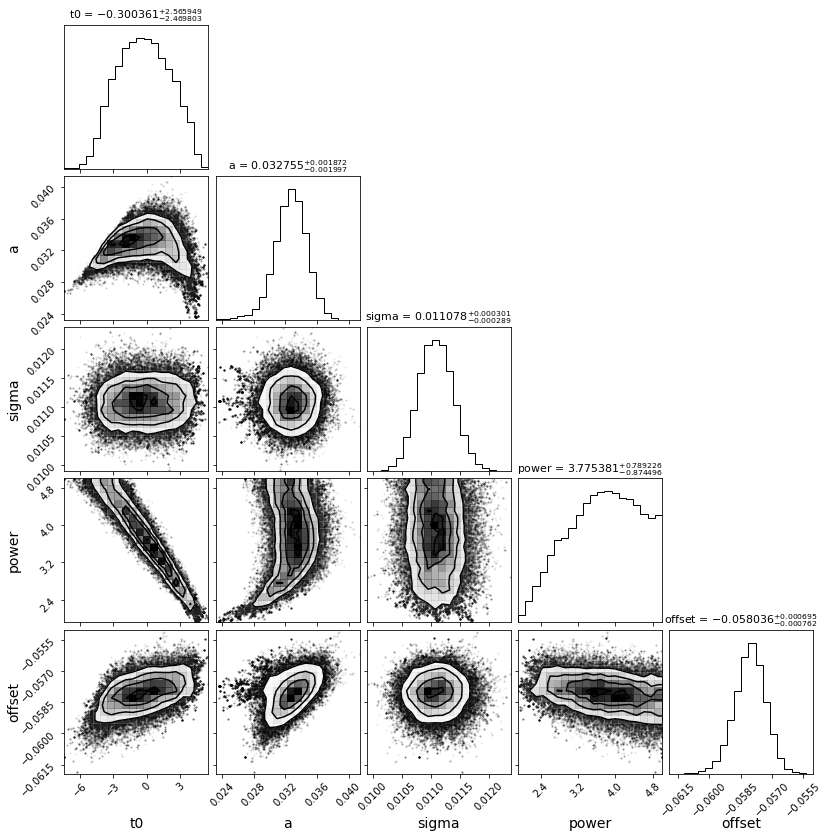

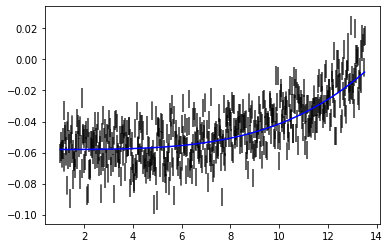

In [30]:
fullEmceePlot(tess_cut,[5, 0.03, 0.0, 3.2, -0.05],scale_off,'model 1')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:21<00:00,  5.98it/s]


done


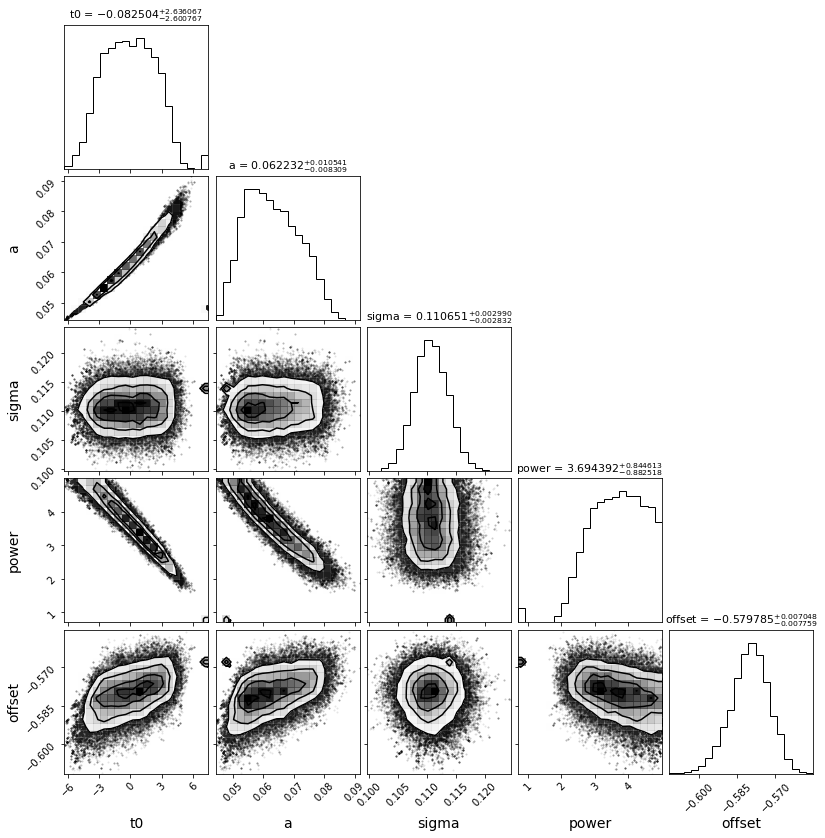

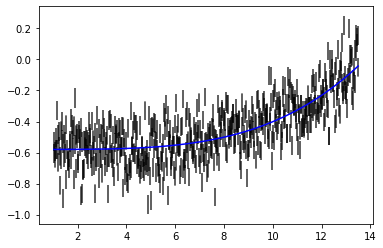

In [17]:
tess_cut_sflux = tess_cut.copy(deep=True)
tess_cut_sflux['flux'] = tess_cut_sflux['flux']*10
tess_cut_sflux['flux_err'] = tess_cut_sflux['flux_err']*10
fullEmceePlot(tess_cut_sflux,[5, 0.03, 0.0, 3.2, -0.05],scale_off,'model 1')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [09:05<00:00,  5.50it/s]


done


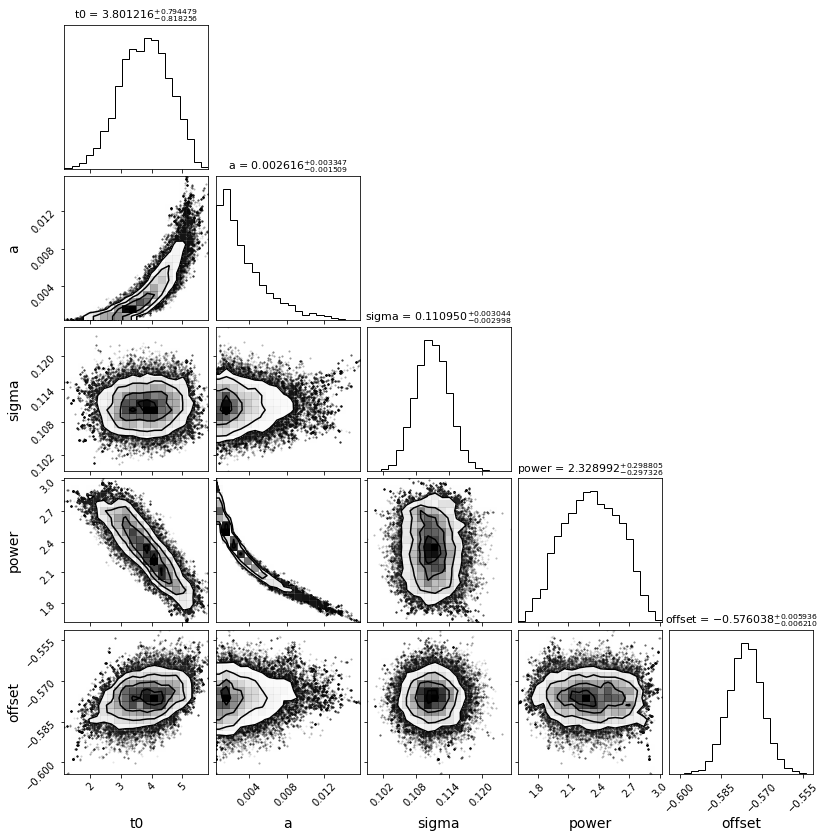

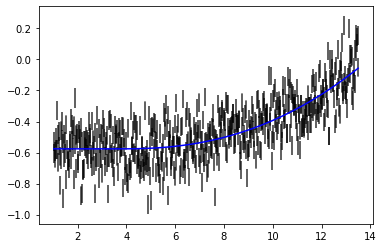

In [35]:
fullEmceePlot(tess_cut_sflux,guess_tess_off,scale_off,'model 0')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [08:38<00:00,  5.78it/s]


done


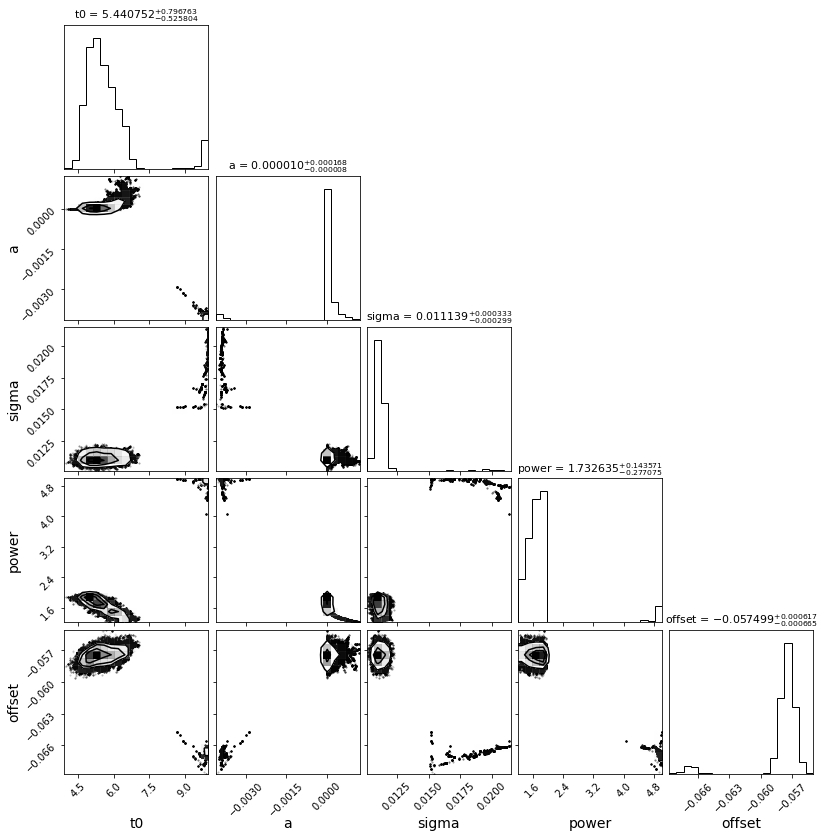

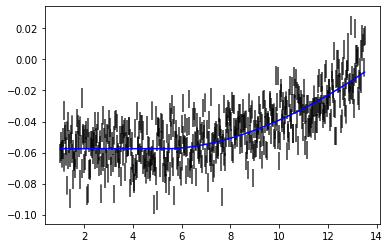

In [31]:
fullEmceePlot(tess_cut,[5, 0.0001, 0.0, 1.8, -0.05],scale_off,'model 2')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [07:57<00:00,  6.28it/s]


done


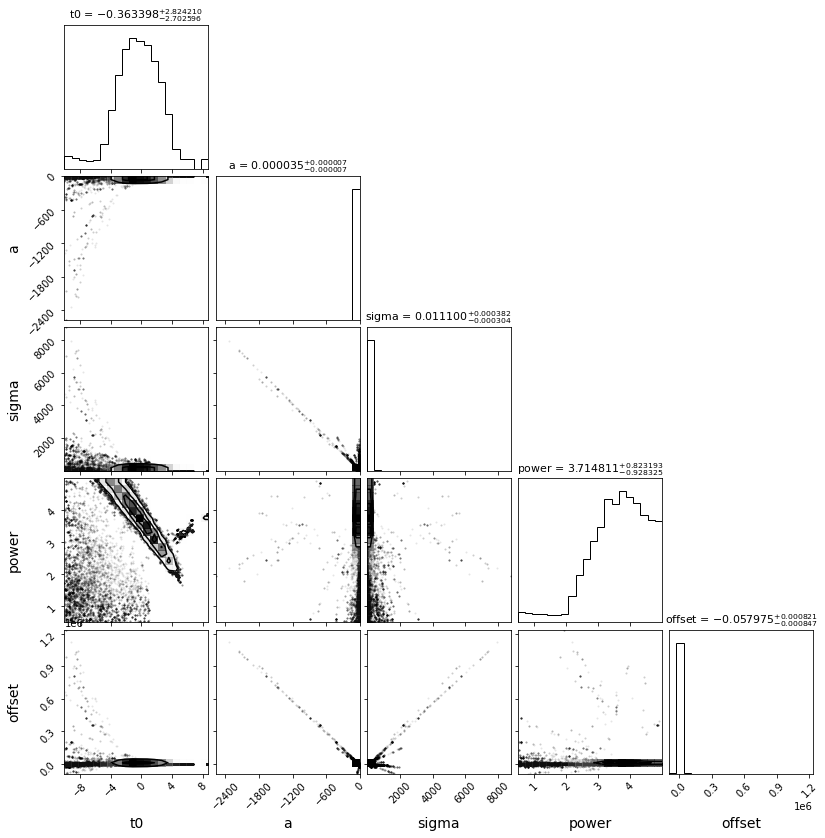

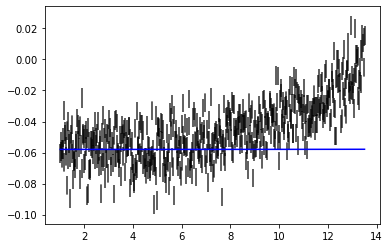

In [18]:
fullEmceePlot(tess_cut,[5, 0.003, 0.0, 3.2, -0.05],scale_off,'model 3')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [07:06<00:00,  7.04it/s]


done


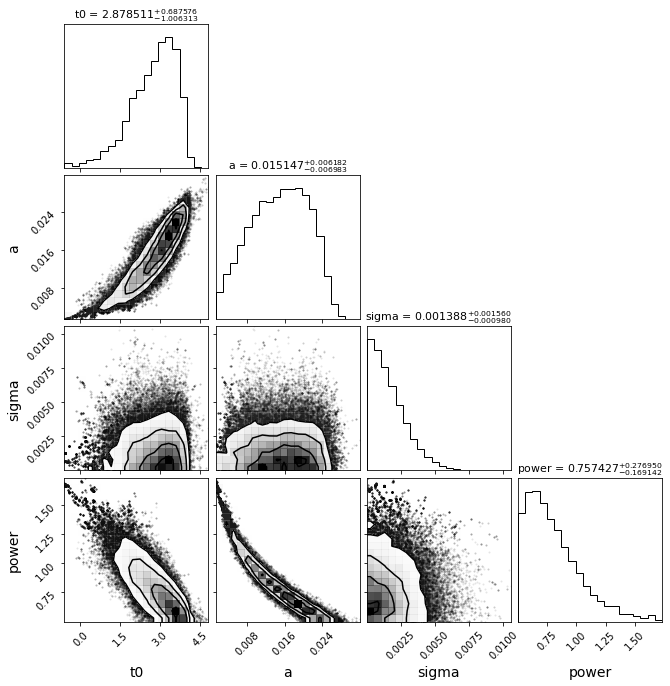

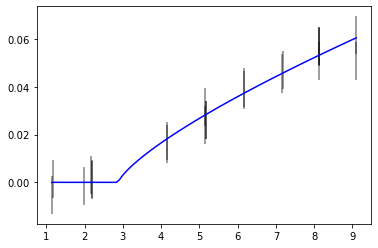

In [21]:
# fullEmceePlot(ztf_cut_0,guess_ztf,scale,'model 0')

  0%|          | 2/3000 [00:00<04:29, 11.14it/s]

sampling...


100%|██████████| 3000/3000 [06:57<00:00,  7.19it/s]


done


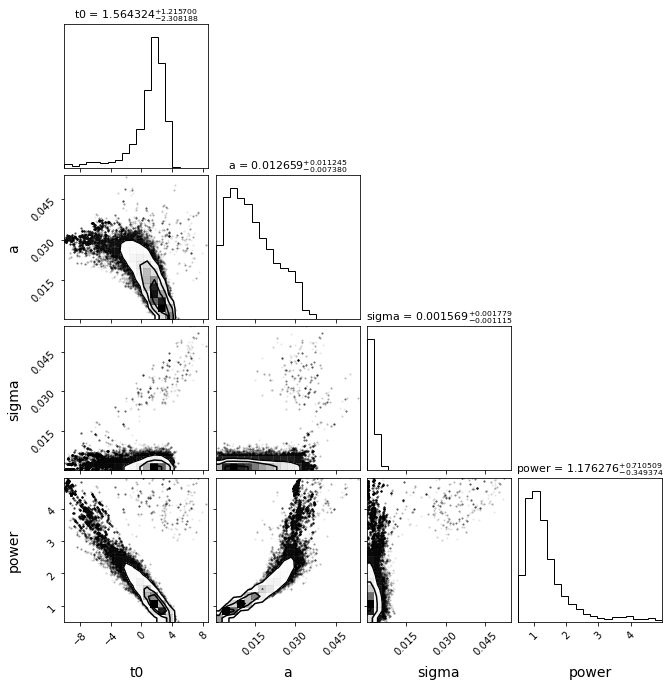

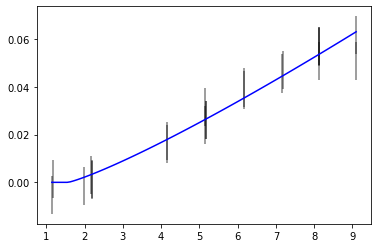

In [22]:
# fullEmceePlot(ztf_cut_0,guess_ztf,scale,'model 1')

  0%|          | 2/3000 [00:00<04:56, 10.13it/s]

sampling...


100%|██████████| 3000/3000 [07:06<00:00,  7.03it/s]


done


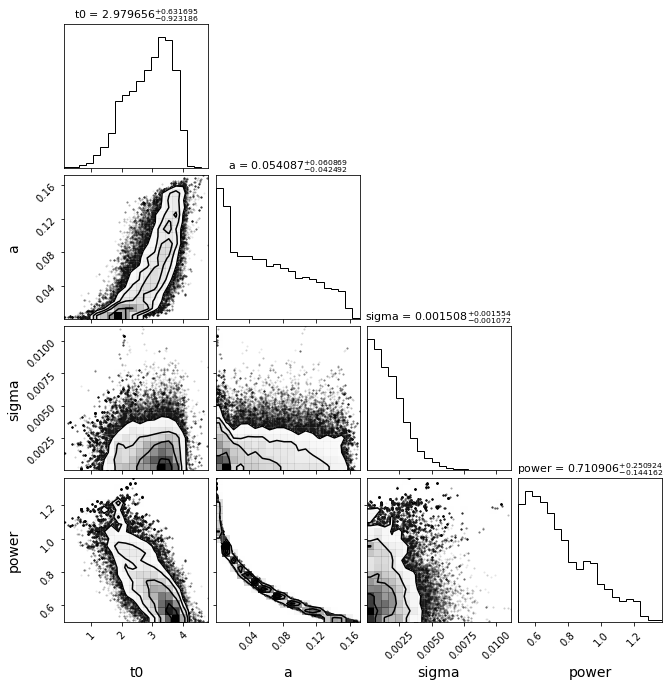

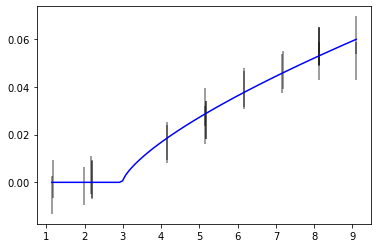

In [23]:
# fullEmceePlot(ztf_cut_0,guess_ztf,scale,'model 2')

  0%|          | 4/3000 [00:00<04:19, 11.54it/s]

sampling...


100%|██████████| 3000/3000 [06:33<00:00,  7.62it/s]


done


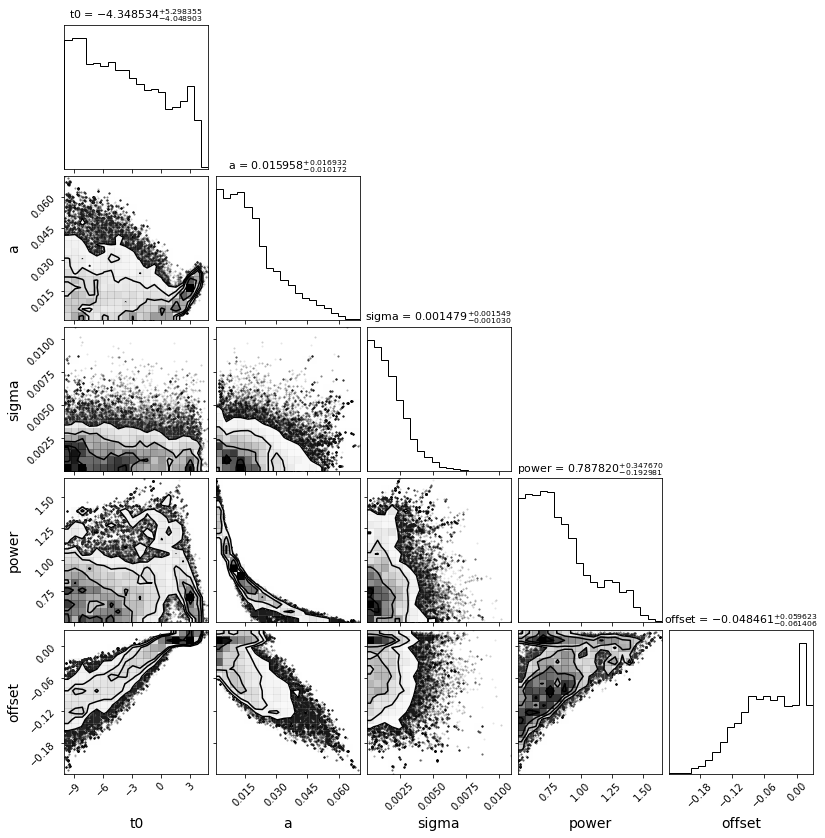

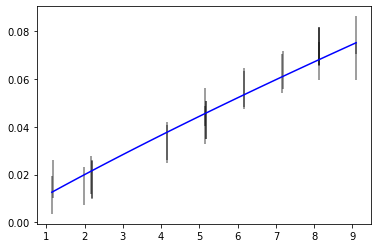

In [24]:
# fullEmceePlot(ztf_cut,guess_ztf_off,scale_off,'model 0')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [06:31<00:00,  7.67it/s]


done


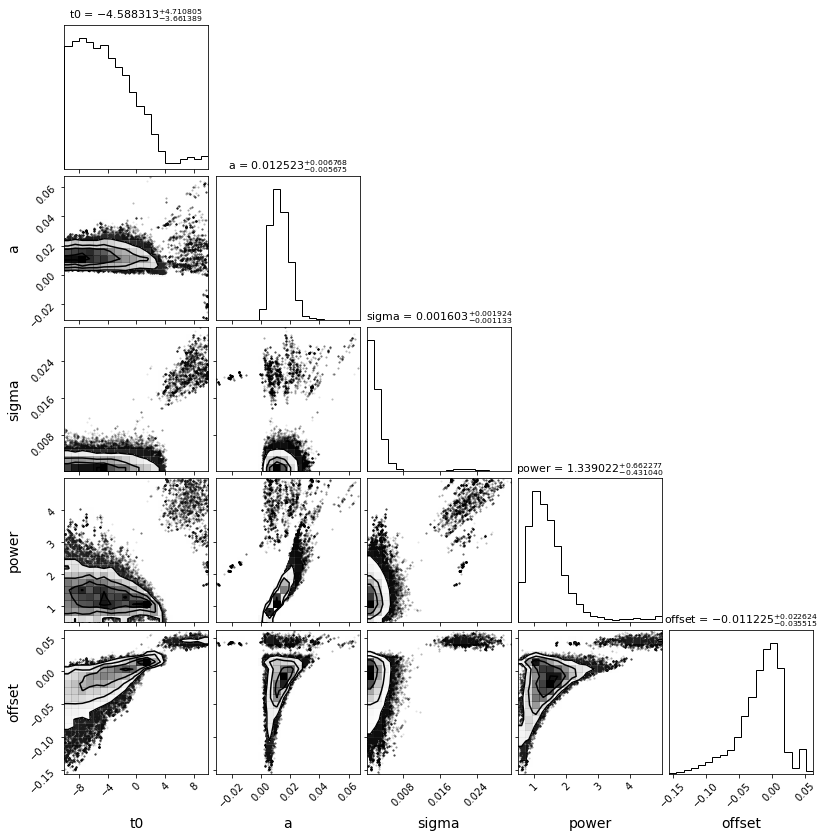

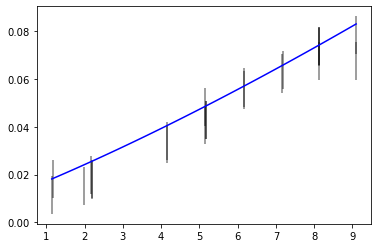

In [25]:
# fullEmceePlot(ztf_cut,guess_ztf_off,scale_off,'model 1')

  0%|          | 2/3000 [00:00<04:01, 12.39it/s]

sampling...


100%|██████████| 3000/3000 [07:01<00:00,  7.11it/s]


done


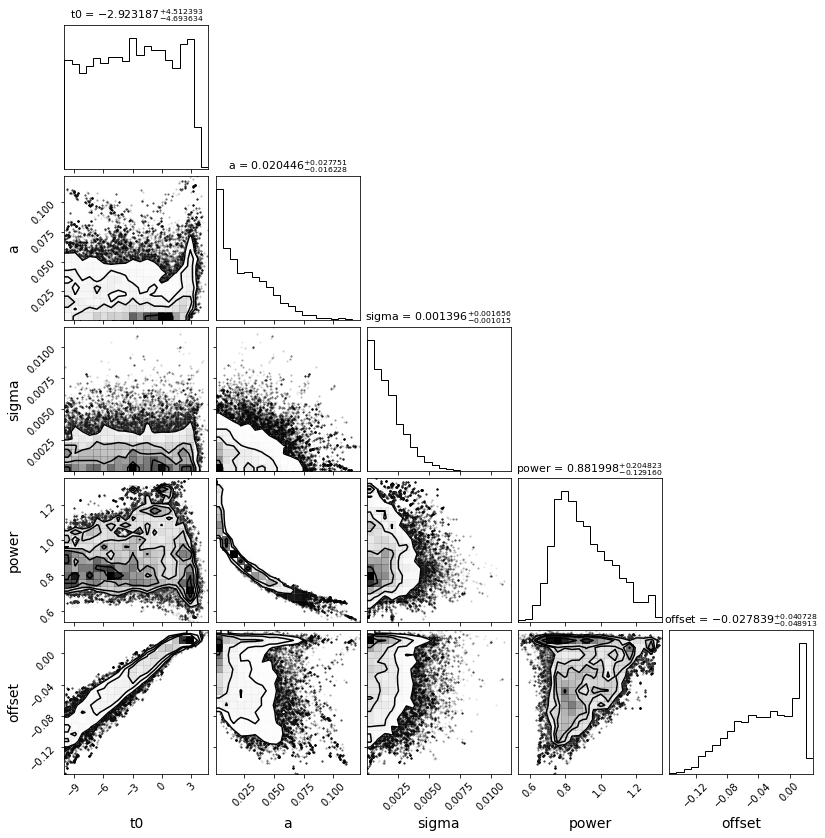

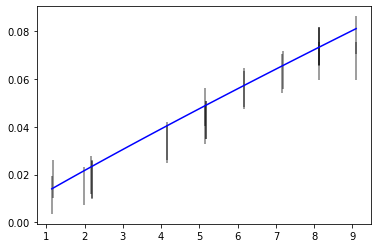

In [26]:
# fullEmceePlot(ztf_cut,guess_ztf_off,scale_off,'model 2')

  0%|          | 0/3000 [00:00<?, ?it/s]

sampling...


100%|██████████| 3000/3000 [07:35<00:00,  6.59it/s]


done


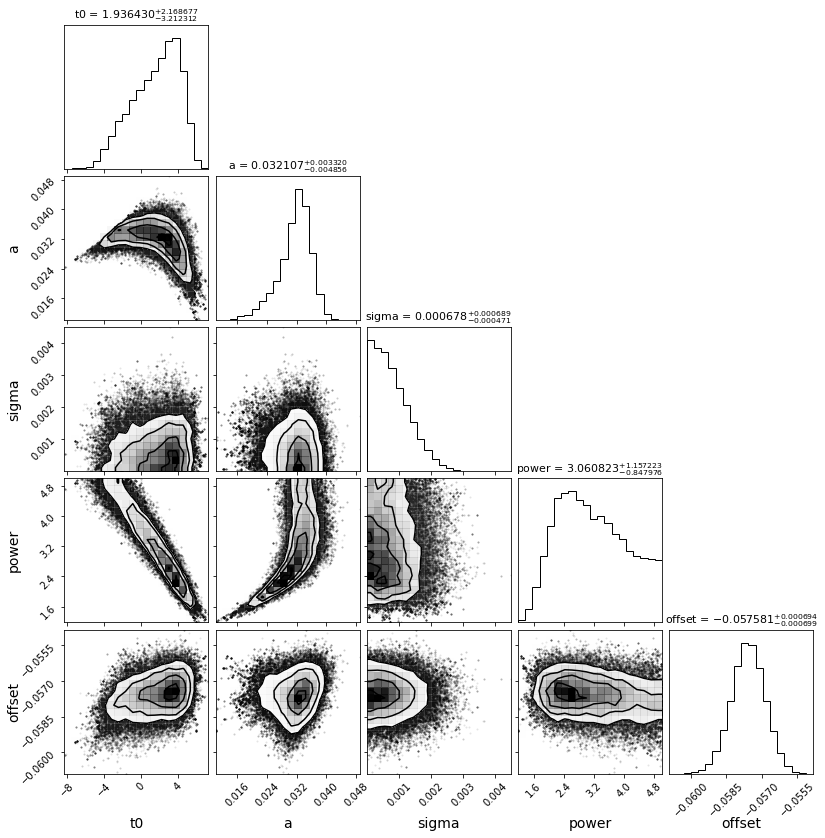

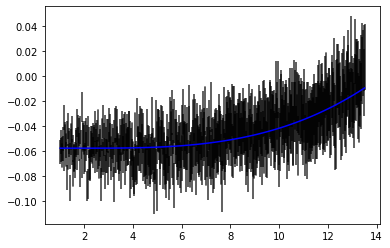

In [27]:
# fullEmceePlot(tess_cut_err,guess_tess_off,scale_off,'model 1')